In [1]:
from IPython.core.debugger import set_trace
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import os
import pandas as pd
import pickle
import pyabc    

import re
from scipy import stats
import seaborn as sns
import tempfile
import theano.tensor as tt

# local
from lib.prior_generation import min_age_prior

## Data Cleaning

In [2]:
calving_data = pd.read_excel('./data/females_calving_2016 up to date.xlsx')
calving_data

,MICS,HWC numbers,80,81,82,83,84,85,86,87,...,08,09,10,11,12,13,14,15,16,Unnamed: 39
0,H002,3229,1.0,NaN,NaN,1.0,1,NaN,NaN,1.0,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,NaN
1,H004,1422,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H008,1417,NaN,NaN,2.0,1.0,1,2.0,NaN,NaN,...,1.0,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,2.000000,NaN
3,H009,1419,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,NaN
4,H035,2088,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,H042,1451,NaN,NaN,NaN,1.0,1,NaN,NaN,1.0,...,2.0,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,2.000000,NaN
6,H044,1424,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,H065,7002,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,H067,7014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,H102,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,...,1.0,NaN,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,NaN


### Only look at those rows with ids

In [3]:
with_ids = calving_data[calving_data['MICS'].notnull() | calving_data['HWC numbers'].notnull()]
# generate our own id for each whale, which is a composite of MICS and HWC numbers.
with_ids.index = with_ids['MICS'].astype(str) + '-' + with_ids['HWC numbers'].astype(str)
with_ids

,MICS,HWC numbers,80,81,82,83,84,85,86,87,...,08,09,10,11,12,13,14,15,16,Unnamed: 39
H002-3229,H002,3229,1.0,NaN,NaN,1.0,1,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN
H004-1422,H004,1422,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H008-1417,H008,1417,NaN,NaN,2.0,1.0,1,2.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,2.0,NaN
H009-1419,H009,1419,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN
H035-2088,H035,2088,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H042-1451,H042,1451,NaN,NaN,NaN,1.0,1,NaN,NaN,1.0,...,2.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,2.0,NaN
H044-1424,H044,1424,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H065-7002,H065,7002,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H067-7014,H067,7014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H102-nan,H102,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,...,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN


In [4]:
def yearify(x):
    """
        Convert strings to years.
        
        The data only has years showing last two digits. We want to convert 
        them into a four-digit number.
        
        Parameters:
        
            x: string, two digits
            
        Returns:
        
            integer year with four digits.
    """
    _x = int(x)
    if _x >= 80:
        return 1900 + _x
    else:
        return 2000 + _x

### Make columns four-digit years

This will enable us to add 1 to the year to get the next year. Previously this doesn't necessarily lead to the correct result. For example 1999 was represented as 99. 99 + 1 = 100 instead of 00 (which stood for 2000).

In [5]:
# Remove some columns we don't care about
unsorted_years_xx = list(set(with_ids.columns) - set(['MICS', 'HWC numbers', 'Unnamed: 39']))

# Get the dataframe where columns are of interest
with_ids_unsorted_years_xx = with_ids[unsorted_years_xx]

# Convert each column into a stringified four-digit year
unsorted_years_xxxx = list(
        map(
            lambda x: str(x),
            map(
                yearify,
                with_ids_unsorted_years_xx.columns
            )
        )
    )

with_ids_unsorted_years_xx.columns = unsorted_years_xxxx
with_ids_unsorted_years_xx

,2013,2011,2012,2009,2016,2002,2004,2006,2001,2015,...,1996,1997,1998,1999,2005,2010,2003,2014,2000,2007
H002-3229,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,2.0,...,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0
H004-1422,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1,2.0,NaN,...,1.0,2.0,1.0,1.0,2.0,1.0,1.0,NaN,1.0,NaN
H008-1417,NaN,1.0,1.0,1.0,2.0,NaN,2.0,2,1.0,1.0,...,NaN,2.0,NaN,2.0,1.0,1.0,1.0,1.0,NaN,1.0
H009-1419,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,2.0,2.0,...,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0
H035-2088,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
H042-1451,1.0,1.0,NaN,1.0,2.0,1.0,NaN,1,NaN,1.0,...,2.0,1.0,NaN,1.0,2.0,1.0,1.0,1.0,1.0,1.0
H044-1424,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,2.0,NaN,...,1.0,1.0,2.0,1.0,1.0,2.0,1.0,NaN,1.0,2.0
H065-7002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H067-7014,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,...,1.0,1.0,1.0,2.0,1.0,NaN,1.0,NaN,1.0,NaN
H102-nan,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN


### Cleaned Matrix

In [6]:
with_ids_sorted_years_xxxx = with_ids_unsorted_years_xx[
    sorted(
        unsorted_years_xxxx
    )
]
with_ids_sorted_years_xxxx

cleaned_matrix = with_ids_sorted_years_xxxx.fillna(value=0).astype(int)
cleaned_matrix


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
H002-3229,1,0,0,1,1,0,0,1,1,2,...,2,1,1,1,1,1,1,1,2,1
H004-1422,0,0,1,2,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
H008-1417,0,0,2,1,1,2,0,0,1,2,...,1,1,1,1,1,1,0,1,1,2
H009-1419,0,0,1,0,0,0,0,1,1,1,...,1,2,1,1,1,1,1,1,2,1
H035-2088,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H042-1451,0,0,0,1,1,0,0,1,2,1,...,1,2,1,1,1,0,1,1,1,2
H044-1424,0,0,1,1,0,1,1,1,1,1,...,2,1,0,2,0,0,0,0,0,0
H065-7002,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
H067-7014,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
H102-nan,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1,1,0,1,1,1


### Heatmap

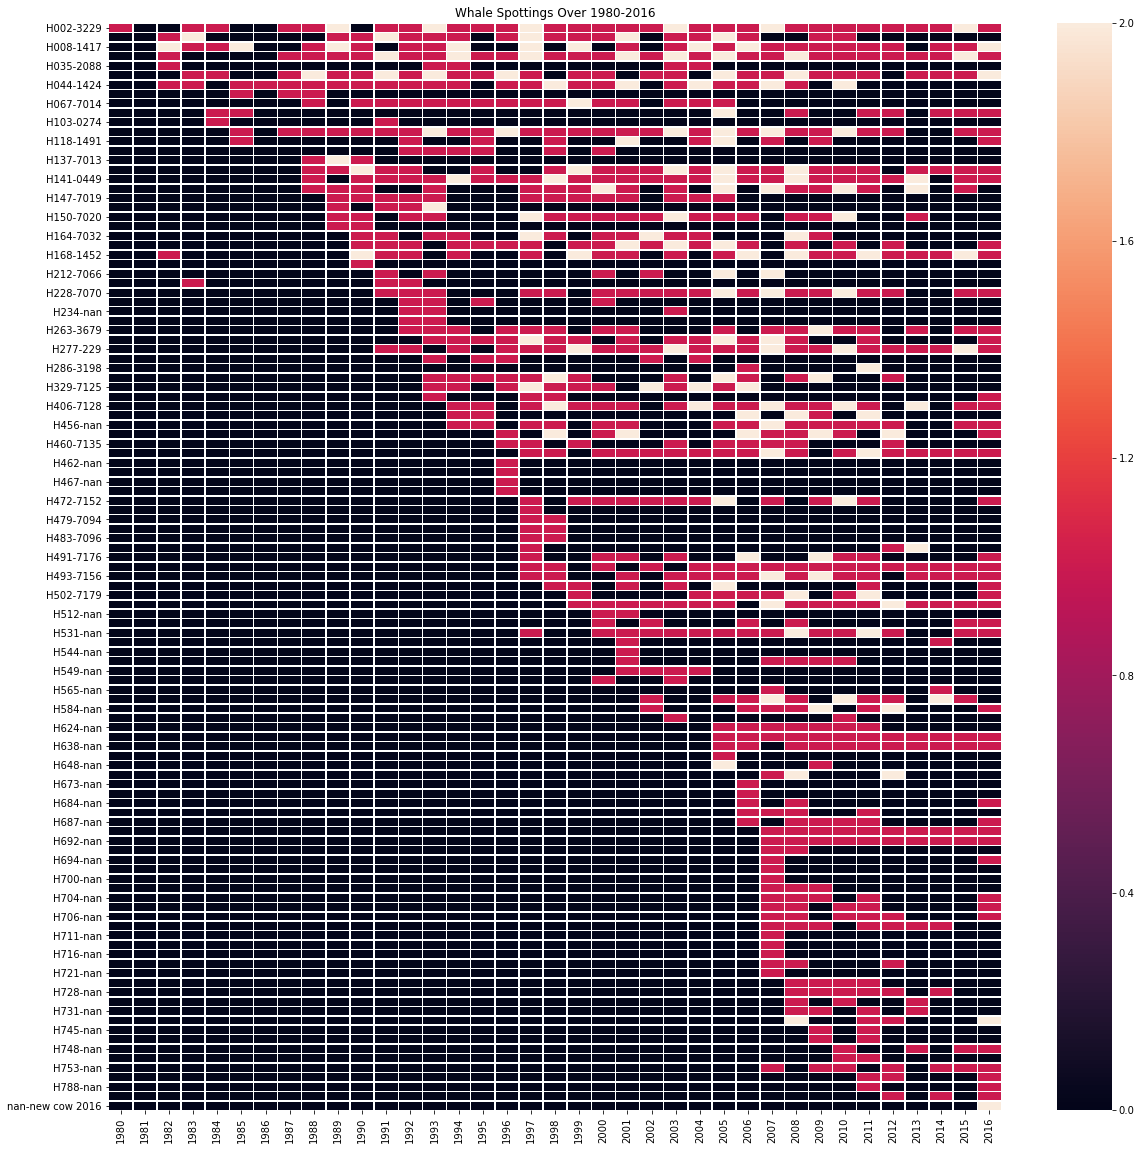

In [7]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.set_title('Whale Spottings Over 1980-2016')
sns.heatmap(cleaned_matrix, ax=ax, linewidths=0.5)

In [8]:
REPRO_AGE = 9
MAX_AVG_AGE = 80
STUDY_START_YEAR_MINUS_1 = 2004
STUDY_END_YEAR = 2016
STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING = list(map(lambda x: str(x), np.arange(STUDY_START_YEAR_MINUS_1, STUDY_END_YEAR + 1)))
STUDY_YEAR_COLUMNS = STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING[1:]
MAX_NUM_POPULATIONS = len(STUDY_YEAR_COLUMNS) * cleaned_matrix.shape[0]

### intro

In [9]:
def intro(age, alive, intro_year_before, proba_intro):
    if age < 0 or (age >= 0 and intro_year_before == 0 and alive == 0):
        return 0
      
    if intro_year_before == 1:
        return 1

    return np.random.binomial(n=1, p=proba_intro)    

### age

In [10]:
def age(age_year_before):
    return age_year_before + 1

### alive

In [11]:
def alive(age, alive_last_year, proba_alive):
    if age < 0:
        return 0
    
    if alive_last_year == 0:
        return 0
    
    if age == 0:
        return 1
    
    return np.random.binomial(n=1, p=proba_alive)

### repro_active

In [12]:
def repro_active(age, alive):
    if alive == 0 or age < 9:
        return 0
    else:
        return 1

### birth

In [13]:
def birth(birth_last_year, repro_active, proba_birth):
    if birth_last_year == 1 or repro_active != 1:
        return 0
    
    return np.random.binomial(n=1, p=proba_birth)

### detect

In [14]:
def detect(intro, alive, proba_detect):
    if intro == 0 or alive == 0:
        return 0
    
    return np.random.binomial(n=1, p=proba_detect)

### count

In [15]:
def count(detect, birth):
    if detect == 1 and birth == 1:
        return 2
    elif detect == 1 and birth == 0:
        return 1
    else:
        return 0

### years_prior_to

In [16]:
def years_prior_to(year, year_columns):
    return list(
        map(
            lambda x: str(x), np.arange(int(year_columns.min()), int(year))
        )
    )

### years_subsequent_to

In [17]:
def years_subsequent_to(year, year_columns):
    return list(
        map(
            lambda x: str(x), np.arange(int(year) + 1, int(year_columns.max()) + 1)
        )
    )

In [18]:

sigma = .5

### model_1

In [19]:
STUDY_START_YEAR_MINUS_1

2004

In [20]:
for year, index in enumerate(STUDY_YEAR_COLUMNS):
    print(year,index)

0 2005
1 2006
2 2007
3 2008
4 2009
5 2010
6 2011
7 2012
8 2013
9 2014
10 2015
11 2016


In [21]:
test_series = pd.Series({'2003': 1, '2004':0, '2005': 1, '2006': 0, '2007': 1})
test_series

2003    1
2004    0
2005    1
2006    0
2007    1
dtype: int64

In [22]:
test_series[years_prior_to(2005, test_series.index)]

2003    1
2004    0
dtype: int64

In [23]:
test_series[years_subsequent_to(2005, test_series.index)]

2006    0
2007    1
dtype: int64

In [24]:
test_series[years_subsequent_to(2007, test_series.index)].sum() >= 1

False

In [25]:
test_series.loc['2004']

0

### initial_alive_t

In [26]:
def initial_alive_t(data, initial_year, proba_alive):
    if data.loc[str(initial_year)] == 1:
        return 1
    elif data[years_prior_to(initial_year, data.index)].sum() >= 1 and \
        data[years_subsequent_to(initial_year, data.index)].sum() >= 1:
            return 1
    else:
        return np.random.binomial(n=1, p=proba_alive)

### initial_intro_t

In [27]:
def initial_intro_t(data, initial_year, proba_intro):
    if data[years_prior_to(initial_year, data.index)].sum() >= 1:
        return 1
    else:
        return np.random.binomial(n=1, p=proba_intro)

### initial_birth_t

In [28]:
def initial_birth_t(data, initial_year, proba_birth):
    if data.loc[str(initial_year)] == 2:
        return 1
    elif data.loc[str(int(initial_year) - 1)] == 2:
        return 1
    else:
        return np.random.binomial(n=1, p=proba_birth)

### initial_detect_t

def initial_detect_t(data, initial_year):
    if data.loc[str(initial_year)] == 1:
        return 1
    else:
        return 0

### observe_alive

In [29]:
def observe_alive(years, data):
    alives = {}
    
    for year in years:
        if data.loc[str(year)] == 1:
            alives[year] = 1
        elif data[years_prior_to(year, data.index)].sum() >= 1 and \
            data[years_subsequent_to(year, data.index)].sum() >= 1:
                alives[year] = 1
        else:
            alives[year] = 0
            
    return pd.Series(alives)

In [30]:
INDIV_DATA = cleaned_matrix.iloc[0]

In [31]:
for i in range(1, len(STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING)):
    print(i, STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING[i])

1 2005
2 2006
3 2007
4 2008
5 2009
6 2010
7 2011
8 2012
9 2013
10 2014
11 2015
12 2016


In [32]:
for t in range(1, len(STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING)):
    print(t, STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING[t])

1 2005
2 2006
3 2007
4 2008
5 2009
6 2010
7 2011
8 2012
9 2013
10 2014
11 2015
12 2016


In [33]:
# YEARS = STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING
# YEARS = ['2004', '2005', '2006', '2007', '2008', '2009']
YEARS = ['2004', '2005']

In [34]:
YEARS

['2004', '2005']

In [35]:
ages = np.arange(-1, -1+12)
ages

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [36]:
possible_alive = (ages >= 0) * 1
possible_alive

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [37]:
earliest_possible_alive_index = (np.where(ages >= 0)[0]).min()

In [38]:
death_index = earliest_possible_alive_index + np.random.geometric(p=0.02)
death_index

13

In [39]:
if death_index < len(possible_alive):
    possible_alive[death_index:] = 0

In [40]:
possible_alive

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

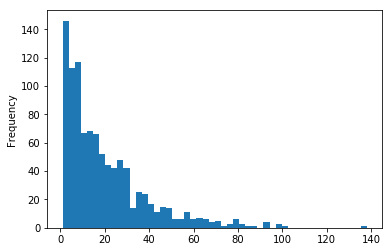

In [41]:
pd.Series(np.random.geometric(p=0.05, size=1000)).plot.hist(bins=50)

In [42]:
repr_actives = (ages >= 9) * possible_alive
repr_actives

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [43]:
births = repr_actives * np.random.binomial(n=1, p=0.5, size=12)
births

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [44]:
detects = possible_alive * np.random.binomial(n=1, p=0.5, size=12)
detects

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [45]:
counts = detects + detects * births
counts

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
STUDY_YEAR_COLUMNS_LENGTH = len(STUDY_YEAR_COLUMNS)

In [124]:
a = np.array([0,0,0])

In [131]:
a[2:] = 1

In [132]:
a

array([0, 0, 1])

In [167]:
def model_2(parameters):
    starting_age = int(parameters['starting_age'])
    
    # print('starting_age', starting_age)
    # print('starting_age + STUDY_YEAR_COLUMNS_LENGTH', starting_age + STUDY_YEAR_COLUMNS_LENGTH)
    ages = np.arange(starting_age, starting_age + STUDY_YEAR_COLUMNS_LENGTH)
    
    # print('len(ages)', len(ages))

    possible_alive = (ages >= 0) * 1
    death_index = earliest_possible_alive_index + np.random.geometric(p=parameters['proba_death'])

    # print('death_index:', death_index)
    # print('A len(possible_alive):', len(possible_alive))

    possible_alive[death_index:] = 0
    
    # print('B len(possible_alive):', len(possible_alive))
        
    repr_actives = (ages >= 9) * possible_alive
    
    p_births = [
        parameters['proba_birth_2005'],
        parameters['proba_birth_2006'],
        parameters['proba_birth_2007'],
        parameters['proba_birth_2008'],
        parameters['proba_birth_2009'],
        parameters['proba_birth_2010'],
        parameters['proba_birth_2011'],
        parameters['proba_birth_2012'],
        parameters['proba_birth_2013'],
        parameters['proba_birth_2014'],
        parameters['proba_birth_2015'],
        parameters['proba_birth_2016'],
    ]
    
    # print('len(ages):', len(ages))
    # print("len(repr_actives):", len(repr_actives))
    births = repr_actives * np.random.binomial(n=1, p=p_births)
    detects = possible_alive * np.random.binomial(n=1, p=parameters['proba_detect'], size=STUDY_YEAR_COLUMNS_LENGTH)
    counts = detects + detects * births
    return {'data': counts}

In [168]:
def model_1(parameters):  
#     for year in STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING:
#         if year != STUDY_START_YEAR_MINUS_1:
#             parameters['proba_detect_' + year]
    data = []
    intros = []
    alives = []
    repro_actives = []
    births = []
    ages = []
    detects = []

    ages.append(parameters['age'])
    
    intros.append(
        initial_intro_t(
            INDIV_DATA, 
            STUDY_START_YEAR_MINUS_1, 
            parameters['proba_intro_' + str(STUDY_START_YEAR_MINUS_1)]
        )
    )

    alives.append(
        initial_alive_t(
            INDIV_DATA, 
            STUDY_START_YEAR_MINUS_1, 
            parameters['proba_alive_' + str(STUDY_START_YEAR_MINUS_1)]
        )
    )
    
    repro_actives.append(
        repro_active(ages[0], alives[0])
    )
    
    births.append(
        initial_birth_t(
            INDIV_DATA, 
            STUDY_START_YEAR_MINUS_1, 
            parameters['proba_birth_' + str(STUDY_START_YEAR_MINUS_1)]
        )
    )
    
    detects.append(
        initial_detect_t(
            INDIV_DATA,
            STUDY_START_YEAR_MINUS_1
        )
    )
      
    for t in range(1, len(YEARS)):
        year_t = YEARS[t]
        ages.append(age(ages[t-1]))
        
        alives.append(
            alive(
                ages[t], 
                alives[t-1], 
                parameters['proba_alive_' + str(year_t)]
            )
        )
        
        
        repro_actives.append(
            repro_active(
                ages[t],
                alives[t]
            )
        )
        
        births.append(
            birth(
                births[t-1], 
                repro_actives[t], 
                parameters['proba_birth_' + str(year_t)]
            )
        )
        
        intros.append(
            intro(
                ages[t], 
                alives[t], 
                intros[t-1], 
                parameters['proba_intro_' + str(year_t)]
            )
        )
        
        detects.append(
            detect(
                intros[t], 
                alives[t], 
                parameters['proba_detect_' + str(year_t)]
            )
        )
        
        data.append(
            count(
                detects[t], 
                births[t]
            )
        )
#     parameters['age']
#     return {'data': pd.Series({'2005': 1, '2006': 1, '2007': 1, '2008': 1, '2009': 1, '2010': 1, '2011': 1, '2012': 1, '2013': 1, '2014': 1, '2015': 1, '2016': 1})}
    
#     return {
#         'data': np.array(alives)
#     }
    return {
        'data': np.array(data)
    }

In [169]:
YEARS

['2004', '2005']

In [170]:
STUDY_YEAR_COLUMNS

['2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016']

In [171]:
new_param_dict = {
    'starting_age': pyabc.RV('uniform', -10, 40),
    'proba_death': pyabc.RV('beta', 1, 20),
    'proba_detect': pyabc.RV('beta', 1, 1),
}

for year in STUDY_YEAR_COLUMNS:
    new_param_dict['proba_birth_' + year] = pyabc.RV('beta', 1, 1)

In [172]:
param_dict = {
    'age': pyabc.RV('uniform', -10, 40)
}

# for year in STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING:
for year in YEARS:
    if year != STUDY_START_YEAR_MINUS_1:
        param_dict['proba_detect_' + year] = pyabc.RV('beta', 3, 1)
    param_dict['proba_alive_' + year] = pyabc.RV('beta', 3, 1)
    param_dict['proba_intro_' + year] = pyabc.RV('beta', 3, 1)
    param_dict['proba_birth_' + year] = pyabc.RV('beta', 1, 3)
    
# param_dict['proba_alive_2005'] = pyabc.RV('beta', 3, 1)
# param_dict['proba_birth_2005'] = pyabc.RV('beta', 1, 3)
# param_dict['proba_intro_2005'] = pyabc.RV('beta', 3, 1)
# param_dict['proba_detect_2005'] = pyabc.RV('beta', 3, 1)

In [173]:
# models = [model_1]

# parameter_priors = [
#     pyabc.Distribution(
#         **param_dict
#     )
# ]

In [174]:
models = [model_2]
parameter_priors = [
    pyabc.Distribution(
        **new_param_dict
    )
]

In [175]:
# We define two models, but they are identical so far
# models = [model_1, model_1]


# # However, our models' priors are not the same.
# # Their mean differs.
# # alpha_1, alpha_2 = 0.7, 1
# parameter_priors = [
#     pyabc.Distribution(proba_detect=pyabc.RV("beta", alpha_1, 1)),
#     pyabc.Distribution(proba_detect=pyabc.RV("beta", alpha_2, 1))
# ]

### distance

In [176]:
sum(abs(np.array([1,2]) - np.array([2,3])))

2

In [177]:
def distance(x, y):
    """
        TODO: we should have multiple distance functions, one for each variable type.
        For example, for alive, we could care only about the observed nodes?
        e.g. let's say we have 2005: 0, 2006: 1, 2007: 1.
            Then we only care about 2006 and 2007
    """ 
    return sum(abs(x['data'] - y['data']))

In [178]:

# We plug all the ABC options together
abc = pyabc.ABCSMC(
    models, parameter_priors,
    distance,
    population_size=500,
    eps=pyabc.ListEpsilon([i for i in reversed(range(35))]),
    sampler=pyabc.sampler.SingleCoreSampler()
)

In [179]:
INDIV_DATA.loc[STUDY_YEAR_COLUMNS].values

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [180]:
observe_alive(STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING, cleaned_matrix.iloc[0])

2004    1
2005    1
2006    1
2007    1
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    1
2016    1
dtype: int64

In [181]:
# y_observed is the important piece here: our actual observation.
y_observed = INDIV_DATA.loc[STUDY_YEAR_COLUMNS].values
# y_observed = observe_alive(STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING, cleaned_matrix.iloc[0])
# and we define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
abc_id = abc.new(db_path, {"data": y_observed})


INFO:History:Start <ABCSMC(id=8, start_time=2019-09-03 13:02:47.919725, end_time=None)>


In [182]:
y_observed

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [183]:

# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.5, max_nr_populations=33)



INFO:ABC:t:0 eps:34
INFO:ABC:t:1 eps:33
INFO:ABC:t:2 eps:32
INFO:ABC:t:3 eps:31
INFO:ABC:t:4 eps:30
INFO:ABC:t:5 eps:29
INFO:ABC:t:6 eps:28
INFO:ABC:t:7 eps:27
INFO:ABC:t:8 eps:26
INFO:ABC:t:9 eps:25
INFO:ABC:t:10 eps:24
INFO:ABC:t:11 eps:23
INFO:ABC:t:12 eps:22
INFO:ABC:t:13 eps:21
INFO:ABC:t:14 eps:20
INFO:ABC:t:15 eps:19
INFO:ABC:t:16 eps:18
INFO:ABC:t:17 eps:17
INFO:ABC:t:18 eps:16
INFO:ABC:t:19 eps:15
INFO:ABC:t:20 eps:14
INFO:ABC:t:21 eps:13
INFO:ABC:t:22 eps:12
INFO:ABC:t:23 eps:11
INFO:ABC:t:24 eps:10
INFO:ABC:t:25 eps:9
INFO:ABC:t:26 eps:8
INFO:ABC:t:27 eps:7
INFO:ABC:t:28 eps:6
INFO:ABC:t:29 eps:5
INFO:ABC:t:30 eps:4
INFO:ABC:t:31 eps:3
INFO:ABC:t:32 eps:2
INFO:History:Done <ABCSMC(id=8, start_time=2019-09-03 13:02:47.919725, end_time=2019-09-03 13:11:26.376841)>


In [186]:
# Evaluate the model probabililties
model_probabilities = history.get_model_probabilities()
model_probabilities

m,0
t,
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0


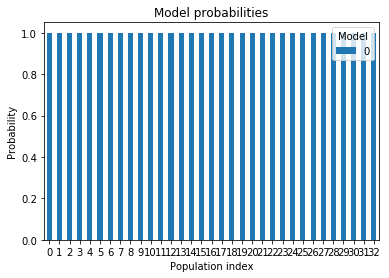

In [187]:
pyabc.visualization.plot_model_probabilities(history)


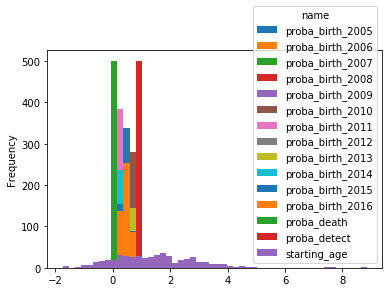

In [188]:
history.get_distribution()[0].plot.hist(bins=50)

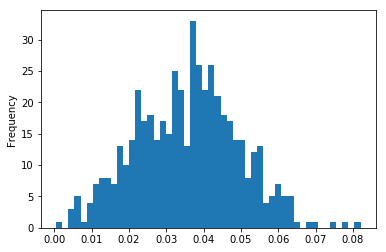

In [191]:
history.get_distribution()[0]['proba_death'].plot.hist(bins=50)

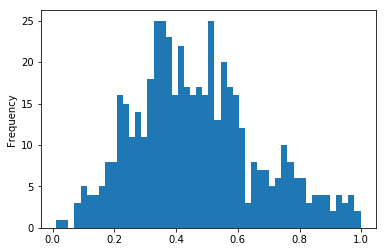

In [192]:
history.get_distribution()[0]['proba_birth_2008'].plot.hist(bins=50)

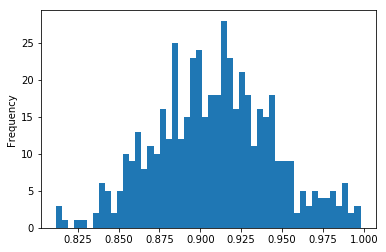

In [193]:
history.get_distribution()[0]['proba_detect'].plot.hist(bins=50)

In [ ]:
dir(history)